# Exercise 4
Task:
- Implement DMDc as shown in Example 3.6
- Test script on data provided in handout 4
- Modify number of singular values and analyze effect on approximation quality





In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

from models import dmd, dmdc
from models import utils
from models import errors

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

### Task 1

a. Turn off the input in the file generate_data. Use the resulting simulation data to perform a DMD using the SVD. Herein adjust the rank r to achieve model order reduction

b. Set up the solution of the obtained linear rank-r linear system and compare the solution to the original solution from generate_data and the one for the full rank DMD.

In [3]:
@jax.jit
def piecewise_step(t: jax.Array) -> jax.Array:
    return (
        (t >= 1).astype(float)
        - 2 * (t >= 2).astype(float)
        -     (t >= 3).astype(float)
        + 4 * (t >= 4).astype(float)
        - 2 * (t >= 6).astype(float)
    )

In [17]:
# Generate Data
z = jnp.linspace(0, 1, 201)
t = jnp.linspace(0, 10, 2001)
u = piecewise_step(t)

p = utils.PDEParams(
    d=0.1, c=-1.2, fun=lambda x, dx, z, t: -0.2 * x + 5 * jnp.sin(x), t=t, u=u, z=z
)

x, z, t = utils.solve_pde_implicit(p)
x = jnp.array(x)

x_ = x[:-1].T       
x_prime = x[1:].T
x_0 = x_[:, 0]   


display("X shape:", x_.shape)
display("X Prime shape:", x_prime.shape)
display("U shape:", u.shape)    


'X shape:'

(201, 2000)

'X Prime shape:'

(201, 2000)

'U shape:'

(2001,)

In [18]:
r, a, phi, lam = dmd.optimize(x_,x_prime, t,(1,20))
result = dmd.simulate(phi, lam,x_0,t)
result = result.real


[[ 2.0000000e+00  1.2025600e-03  1.2026425e-03 ...  1.3788700e-03
   1.3789645e-03  1.3790590e-03]
 [ 2.0615804e+00  2.1347918e-03  2.1349383e-03 ...  2.4477784e-03
   2.4479462e-03  2.4481139e-03]
 [ 2.1205876e+00  3.1079424e-03  3.1081554e-03 ...  3.5636048e-03
   3.5638490e-03  3.5640930e-03]
 ...
 [-1.8695493e+00  1.6599116e-01  1.6600254e-01 ...  1.9032750e-01
   1.9034053e-01  1.9035359e-01]
 [-1.9359528e+00  1.1294551e-01  1.1295325e-01 ...  1.2950470e-01
   1.2951358e-01  1.2952246e-01]
 [-2.0000000e+00  5.6499030e-02  5.6502905e-02 ...  6.4782478e-02
   6.4786918e-02  6.4791359e-02]]
Error: 0.29577315
[[ 2.0000000e+00  2.2828834e-02  2.2746235e-02 ...  1.4338052e-04
   1.4367292e-04  1.4396249e-04]
 [ 2.0615804e+00  4.4899814e-02  4.4731081e-02 ...  3.1228596e-04
   3.1279522e-04  3.1329889e-04]
 [ 2.1205876e+00  6.7353152e-02  6.7097470e-02 ...  4.8086193e-04
   4.8159884e-04  4.8232736e-04]
 ...
 [-1.8695493e+00 -2.8150180e-02 -2.3488522e-02 ... -2.2189710e-02
  -2.2142194e-

In [19]:
u = u[:x.shape[0]-1].reshape(1,-1)
r_c, a_c, b_c, phi_c, lam_c = dmdc.optimize(x_,x_prime,u, t, (1,20))
display(r_c)

1

In [20]:
result_c = dmdc.simulate(x_0, u.T, a_c, b_c, phi_c)
result_c = result_c.real



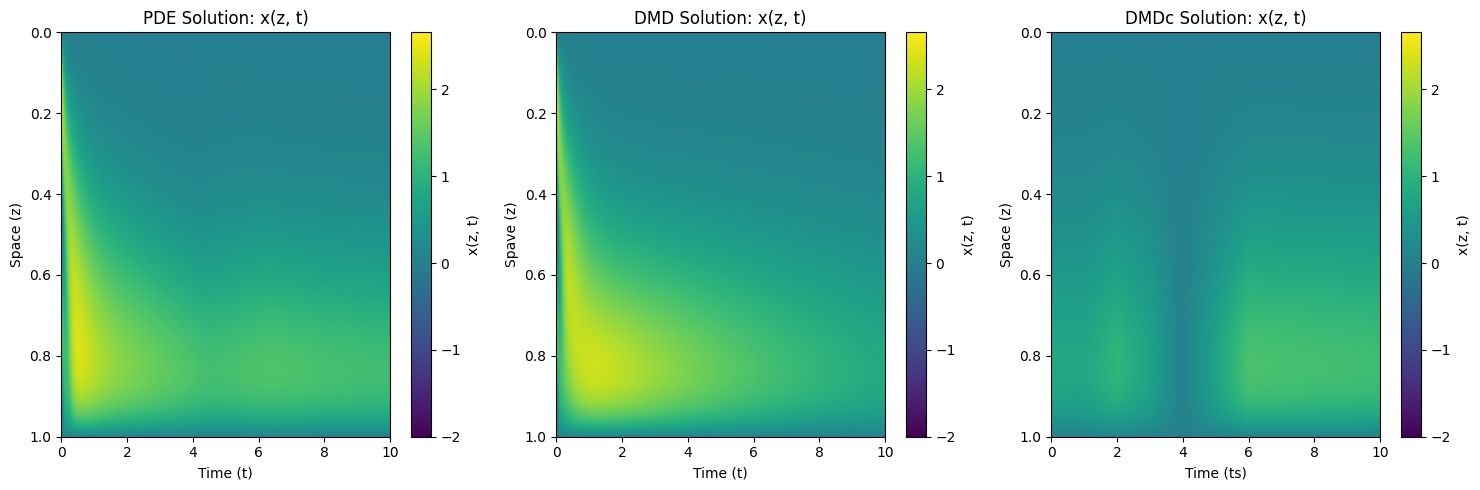

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(x.T, extent=[t[0], t[-1], z[-1], z[0]], aspect='auto', cmap='viridis')
plt.colorbar(label='x(z, t)')
plt.xlabel('Time (t)')
plt.ylabel('Space (z)')
plt.title('PDE Solution: x(z, t)')

plt.subplot(1, 3, 2)
plt.imshow(result.T, extent=[t[0], t[-1], z[-1], z[0]], aspect='auto', cmap='viridis')
plt.colorbar(label='x(z, t)')
plt.xlabel('Time (t)')
plt.ylabel('Spave (z)')
plt.title('DMD Solution: x(z, t)')

plt.subplot(1, 3, 3)
plt.imshow(result_c.T, extent=[t[0], t[-1], z[-1], z[0]], aspect='auto', cmap='viridis')
plt.colorbar(label='x(z, t)')
plt.xlabel('Time (t)')
plt.ylabel('Space (z)')
plt.title('DMDc Solution: x(z, t)')

plt.tight_layout()
plt.show()

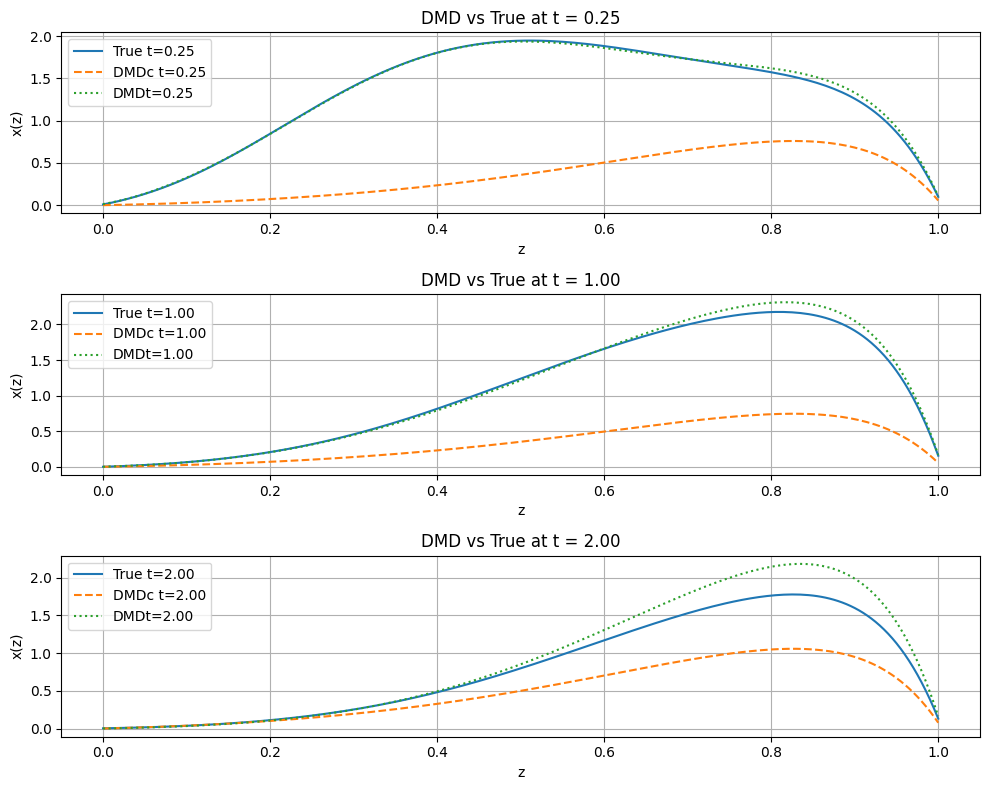

In [23]:
plt.figure(figsize=(10, 8))
for index, i in enumerate([50, 200, 400]):
    plt.subplot(3, 1, index +1)
    plt.plot(z, x[i], label=f"True t={t[i]:.2f}")
    plt.plot(z, result_c.T[:, i], "--", label=f"DMDc t={t[i]:.2f}")
    plt.plot(z, result.T[:, i], ":", label=f"DMDt={t[i]:.2f}")
    plt.xlabel("z")
    plt.ylabel("x(z)")
    plt.legend()
    plt.title("DMD vs True at t = {:.2f}".format(t[i]))
    plt.grid(True)
plt.tight_layout()
plt.show()
